<a href="https://colab.research.google.com/github/seyed-mohammadreza-mousavi/ml-playground-starter/blob/main/logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regression — A Complete, Hands-On Tutorial

**What you’ll learn**  
- The math behind logistic regression (sigmoid, log-loss, gradients)  
- Training a model **from scratch** with NumPy (including **L2 regularization** & **early stopping**)  
- Building production-ready pipelines with **scikit-learn**  
- **Evaluation**: accuracy, precision/recall/F1, confusion matrix, ROC-AUC, PR-AUC  
- Dealing with **class imbalance**, **regularization paths**, **calibration**, and **interpretation** (odds ratios)  
- **Multiclass** (One-vs-Rest) and **hyperparameter tuning** with cross-validation  
- Saving/loading models for deployment

> All charts use Matplotlib; no external internet is required. Run cells from top to bottom.  
> For reproducibility, a fixed `random_state=42` is used throughout.

## 1. Setup & Imports

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification, make_moons, load_iris
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, roc_curve, roc_auc_score,
                             average_precision_score, precision_recall_curve, classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibrationDisplay
from sklearn.utils.class_weight import compute_class_weight

import joblib

RANDOM_STATE = 42
np.set_printoptions(suppress=True, precision=4)
pd.set_option("display.max_columns", 100)
print("Imports ready.")

Imports ready.


## 2. Create a Binary Classification Dataset

In [9]:
# We'll create two datasets:
# (A) A linearly-separable-ish dataset from make_classification
# (B) A non-linear dataset (moons) for decision-boundary visualization

X_lin, y_lin = make_classification(
    n_samples=1200, n_features=5, n_informative=3, n_redundant=0, n_repeated=0,
    n_clusters_per_class=2, class_sep=1.5, flip_y=0.03, random_state=RANDOM_STATE
)

# A compact 2D dataset for plotting decision boundaries
X_2d, y_2d = make_moons(n_samples=800, noise=0.2, random_state=RANDOM_STATE)

lin = pd.DataFrame(np.column_stack([X_lin, y_lin]), columns=[f"x{i}" for i in range(5)] + ["target"])
moons = pd.DataFrame(np.column_stack([X_2d, y_2d]), columns=["x0","x1","target"])

print("Linear-ish dataset shape:", lin.shape)
print("Moons dataset shape:", moons.shape)
lin.head()

Linear-ish dataset shape: (1200, 6)
Moons dataset shape: (800, 3)


,x0,x1,x2,x3,x4,target
0,-1.880317,-0.865789,-1.400784,0.289184,-0.020561,0.0
1,0.416061,3.693032,2.885113,2.098221,0.457324,1.0
2,2.061875,-1.636068,-1.092636,0.504483,-0.610858,0.0
3,1.691230,2.248623,1.455631,-1.042272,-0.195785,1.0
4,1.795291,-0.115348,0.879756,-0.630931,-1.114081,1.0


## 3. Split Data (Train/Test)

In [10]:
Xtr, Xte, ytr, yte = train_test_split(X_lin, y_lin, test_size=0.25, stratify=y_lin, random_state=RANDOM_STATE)
print("Train size:", Xtr.shape, " Test size:", Xte.shape)

Train size: (900, 5)  Test size: (300, 5)


## 4. Quick Look at the 2D Dataset

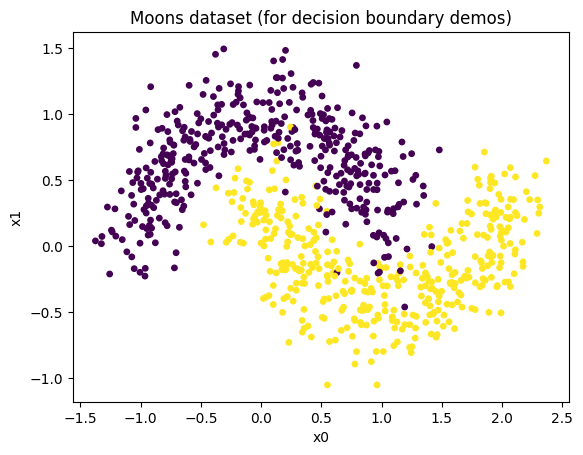

In [11]:
plt.figure()
plt.scatter(X_2d[:,0], X_2d[:,1], c=y_2d, s=15)
plt.title("Moons dataset (for decision boundary demos)")
plt.xlabel("x0")
plt.ylabel("x1")
plt.show()

## 5. Math Background (Binary Logistic Regression)

**Sigmoid (logistic) function**

$$
\sigma(z) = \frac{1}{1 + e^{-z}}, \quad z = \mathbf{w}^\top \mathbf{x} + b
$$

**Probability model**

$$
\hat{p}(y=1 \mid \mathbf{x}) = \sigma(\mathbf{w}^\top \mathbf{x} + b)
$$

**Binary cross-entropy (log-loss) with L2**

$$
\mathcal{L}(\mathbf{w}, b) = -\frac{1}{N}\sum_{i=1}^{N}
\Big( y_i \log \hat{p}_i + (1-y_i)\log (1-\hat{p}_i) \Big)
+ \frac{\lambda}{2}\|\mathbf{w}\|_2^2
$$

**Gradients**

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{w}} =
\frac{1}{N}\mathbf{X}^\top(\hat{\mathbf{p}} - \mathbf{y}) + \lambda \mathbf{w}
$$

$$
\frac{\partial \mathcal{L}}{\partial b} =
\frac{1}{N}\sum_{i=1}^{N} (\hat{p}_i - y_i)
$$

We’ll implement gradient descent with optional early stopping.

## 6. From-Scratch Logistic Regression with NumPy

In [12]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def log_loss(y_true, y_prob, l2, w):
    eps = 1e-15
    y_prob = np.clip(y_prob, eps, 1 - eps)
    ce = -(y_true * np.log(y_prob) + (1 - y_true) * np.log(1 - y_prob)).mean()
    reg = 0.5 * l2 * np.sum(w * w)
    return ce + reg

def predict_proba_np(X, w, b):
    return sigmoid(X @ w + b)

def accuracy_np(y_true, y_prob, thresh=0.5):
    yhat = (y_prob >= thresh).astype(int)
    return (yhat == y_true).mean()

def fit_logreg_gd(X, y, lr=0.1, l2=0.0, n_iter=2000, tol=1e-6, early_stopping=True, patience=20, verbose=True):
    n, d = X.shape
    # Standardize features (important for GD)
    mu = X.mean(axis=0)
    sigma = X.std(axis=0) + 1e-12
    Xs = (X - mu) / sigma

    # Initialize parameters
    rng = np.random.default_rng(RANDOM_STATE)
    w = rng.normal(scale=0.01, size=d)
    b = 0.0

    best_loss = np.inf
    best_wb = (w.copy(), b)
    patience_left = patience
    history = []

    for t in range(1, n_iter + 1):
        p = predict_proba_np(Xs, w, b)
        loss = log_loss(y, p, l2, w)
        history.append(loss)

        # Gradients
        grad_p = (p - y) / n
        grad_w = Xs.T @ grad_p + l2 * w
        grad_b = grad_p.sum()

        # Update
        w -= lr * grad_w
        b -= lr * grad_b

        # Early stopping check
        if early_stopping:
            if loss + tol < best_loss:
                best_loss = loss
                best_wb = (w.copy(), b)
                patience_left = patience
            else:
                patience_left -= 1
                if patience_left <= 0:
                    if verbose:
                        print(f"Early stopping at iter={t}, best_loss={best_loss:.6f}")
                    break

    # Restore best
    w, b = best_wb
    # Package scaler params for later use
    model = {"w": w, "b": b, "mu": mu, "sigma": sigma, "l2": l2}
    return model, np.array(history)

def predict_proba_model(model, X):
    Xs = (X - model["mu"]) / model["sigma"]
    return predict_proba_np(Xs, model["w"], model["b"])

def predict_model(model, X, thresh=0.5):
    return (predict_proba_model(model, X) >= thresh).astype(int)

# Train on the linear-ish dataset
model_np, hist = fit_logreg_gd(Xtr, ytr, lr=0.2, l2=0.01, n_iter=5000, patience=100, verbose=True)
print("Final training loss:", hist[-1])

Early stopping at iter=780, best_loss=0.255445
Final training loss: 0.2554441443228468


### Training Loss Curve

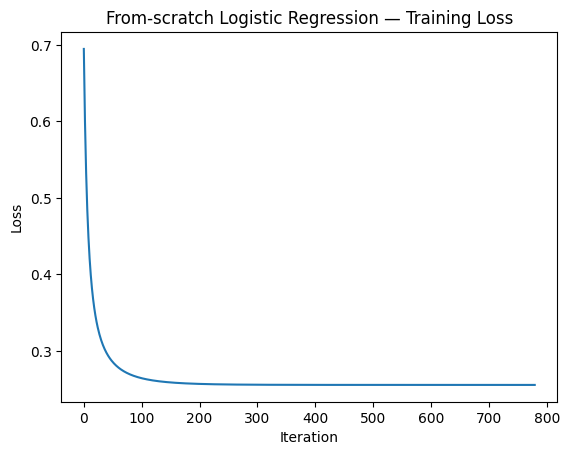

In [13]:
plt.figure()
plt.plot(hist)
plt.title("From-scratch Logistic Regression — Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

### Evaluate the From-Scratch Model

In [14]:
proba_tr = predict_proba_model(model_np, Xtr)
proba_te = predict_proba_model(model_np, Xte)

for split, y_true, y_prob in [("Train", ytr, proba_tr), ("Test", yte, proba_te)]:
    yhat = (y_prob >= 0.5).astype(int)
    acc = accuracy_score(y_true, yhat)
    prec = precision_score(y_true, yhat)
    rec = recall_score(y_true, yhat)
    f1 = f1_score(y_true, yhat)
    auc = roc_auc_score(y_true, y_prob)
    print(f"{split}: acc={acc:.3f} prec={prec:.3f} rec={rec:.3f} f1={f1:.3f} roc_auc={auc:.3f}")

print("\nConfusion matrix (Test):")
print(confusion_matrix(yte, (proba_te >= 0.5).astype(int)))
print("\nClassification report (Test):")
print(classification_report(yte, (proba_te >= 0.5).astype(int)))

Train: acc=0.937 prec=0.925 rec=0.952 f1=0.938 roc_auc=0.968
Test: acc=0.930 prec=0.922 rec=0.940 f1=0.931 roc_auc=0.971

Confusion matrix (Test):
[[137  12]
 [  9 142]]

Classification report (Test):
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       149
           1       0.92      0.94      0.93       151

    accuracy                           0.93       300
   macro avg       0.93      0.93      0.93       300
weighted avg       0.93      0.93      0.93       300



## 7. scikit-learn Pipeline & Baseline Model

In [15]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(random_state=RANDOM_STATE, max_iter=2000))
])

pipe.fit(Xtr, ytr)
yprob_te = pipe.predict_proba(Xte)[:,1]
yhat_te = (yprob_te >= 0.5).astype(int)
print("Test accuracy:", accuracy_score(yte, yhat_te))
print("ROC AUC:", roc_auc_score(yte, yprob_te))

Test accuracy: 0.9266666666666666
ROC AUC: 0.9708431485843815


### ROC & Precision-Recall Curves

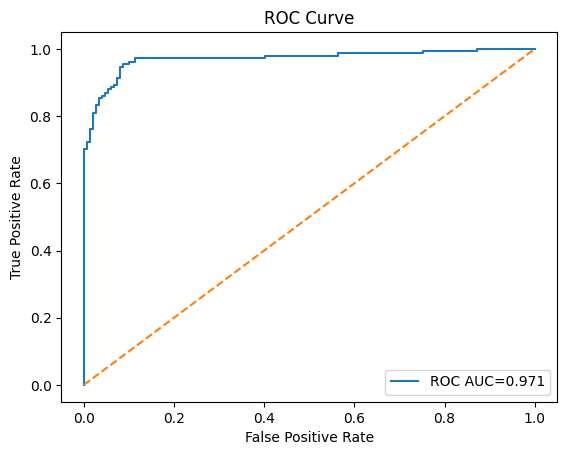

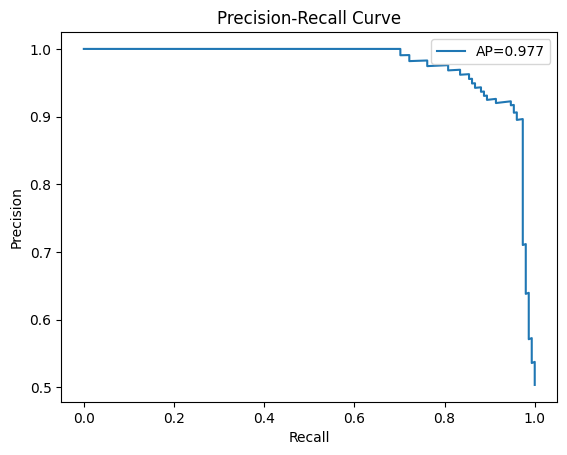

In [16]:
# ROC
fpr, tpr, _ = roc_curve(yte, yprob_te)
auc = roc_auc_score(yte, yprob_te)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC AUC={auc:.3f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Precision-Recall
prec, rec, _ = precision_recall_curve(yte, yprob_te)
ap = average_precision_score(yte, yprob_te)
plt.figure()
plt.plot(rec, prec, label=f"AP={ap:.3f}")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

## 8. Decision Boundary (2D Example)

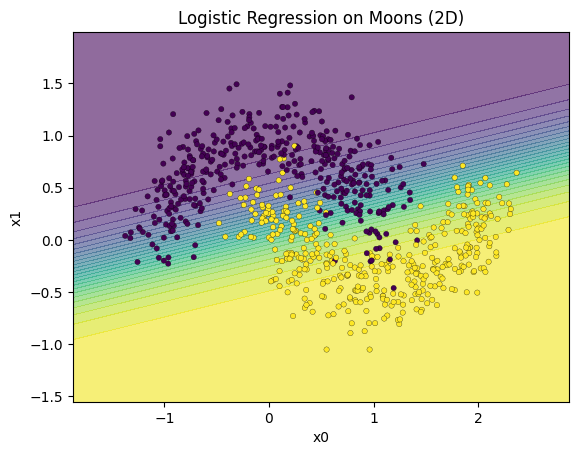

In [17]:
def plot_decision_boundary_2d(clf, X, y, title="Decision Boundary"):
    # Assumes clf has predict_proba and we will scale inside pipeline if needed
    x_min, x_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5
    y_min, y_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = clf.predict_proba(grid)[:,1].reshape(xx.shape)
    plt.figure()
    plt.contourf(xx, yy, probs, levels=25, alpha=0.6)
    plt.scatter(X[:,0], X[:,1], c=y, s=15, edgecolor="k", linewidth=0.2)
    plt.title(title)
    plt.xlabel("x0")
    plt.ylabel("x1")
    plt.show()

pipe_2d = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(random_state=RANDOM_STATE, max_iter=2000))
])
pipe_2d.fit(X_2d, y_2d)
plot_decision_boundary_2d(pipe_2d, X_2d, y_2d, title="Logistic Regression on Moons (2D)")

## 9. Handling Class Imbalance

In [18]:
# Create an imbalanced dataset
Xi, yi = make_classification(n_samples=2000, n_features=6, weights=[0.9, 0.1],
                             n_informative=4, class_sep=1.0, random_state=RANDOM_STATE)
Xi_tr, Xi_te, yi_tr, yi_te = train_test_split(Xi, yi, test_size=0.25, stratify=yi, random_state=RANDOM_STATE)

# Baseline without class weights
pipe_i_base = Pipeline([("scaler", StandardScaler()),
                        ("logreg", LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))])
pipe_i_base.fit(Xi_tr, yi_tr)
probi = pipe_i_base.predict_proba(Xi_te)[:,1]
print("No class weights — AP:", average_precision_score(yi_te, probi))

# With 'balanced' class weights
pipe_i_bal = Pipeline([("scaler", StandardScaler()),
                       ("logreg", LogisticRegression(class_weight="balanced", max_iter=2000, random_state=RANDOM_STATE))])
pipe_i_bal.fit(Xi_tr, yi_tr)
probi_bal = pipe_i_bal.predict_proba(Xi_te)[:,1]
print("Balanced class weights — AP:", average_precision_score(yi_te, probi_bal))

No class weights — AP: 0.4847005225066459
Balanced class weights — AP: 0.34411410301684187


## 10. Hyperparameter Tuning (Cross-Validation)

In [25]:
param_grid = {
    "logreg__C": [0.01, 0.1, 1.0, 10.0],
    "logreg__penalty": ["l2"],
    "logreg__solver": ["lbfgs", "liblinear"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
grid = GridSearchCV(
    Pipeline([("scaler", StandardScaler()), ("logreg", LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))]),
    param_grid=param_grid, cv=cv, scoring="roc_auc", n_jobs=None
)
grid.fit(Xtr, ytr)
print("Best params:", grid.best_params_)
print("Best CV score (ROC AUC):", grid.best_score_)
best_model = grid.best_estimator_
print("Test ROC AUC:", roc_auc_score(yte, best_model.predict_proba(Xte)[:,1]))

Best params: {'logreg__C': 10.0, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
Best CV score (ROC AUC): 0.968045437708359
Test ROC AUC: 0.9710209342637449


## 11. Model Interpretation — Coefficients & Odds Ratios

In [26]:
# Fit a simple, well-regularized model
pipe_small = Pipeline([("scaler", StandardScaler()),
                       ("logreg", LogisticRegression(C=1.0, penalty="l2", solver="lbfgs", max_iter=2000, random_state=RANDOM_STATE))])
pipe_small.fit(Xtr, ytr)

# Extract coefficients (after scaling). In a pipeline, coefficients are with respect to scaled features.
coef = pipe_small.named_steps["logreg"].coef_.ravel()
features = [f"x{i}" for i in range(Xtr.shape[1])]
odds_ratios = np.exp(coef)

interp_df = pd.DataFrame({"feature": features, "coef": coef, "odds_ratio (exp(coef))": odds_ratios}).sort_values("coef", ascending=False)
interp_df.reset_index(drop=True, inplace=True)
interp_df

,feature,coef,odds_ratio (exp(coef))
0,x1,3.417901,30.505328
1,x2,0.797324,2.219593
2,x0,0.318059,1.374457
3,x3,0.198022,1.218989
4,x4,0.063266,1.065310


## 12. Regularization Path (Effect of C)

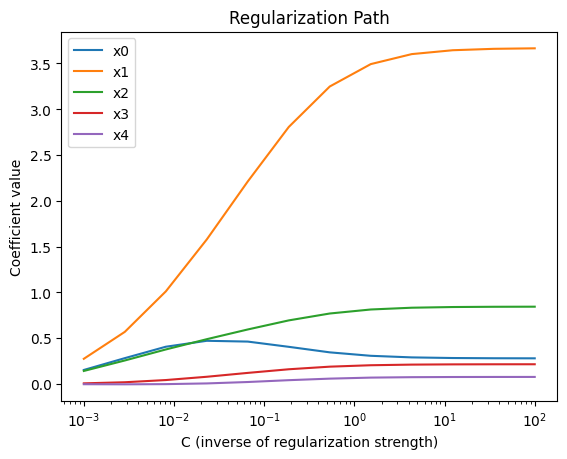

In [27]:
Cs = np.logspace(-3, 2, 12)
coefs = []
for C in Cs:
    lr = Pipeline([("scaler", StandardScaler()),
                   ("logreg", LogisticRegression(C=C, solver="lbfgs", max_iter=2000, random_state=RANDOM_STATE))])
    lr.fit(Xtr, ytr)
    coefs.append(lr.named_steps["logreg"].coef_.ravel())
coefs = np.array(coefs)

plt.figure()
for j in range(coefs.shape[1]):
    plt.plot(Cs, coefs[:, j], label=f"x{j}")
plt.xscale("log")
plt.xlabel("C (inverse of regularization strength)")
plt.ylabel("Coefficient value")
plt.title("Regularization Path")
plt.legend()
plt.show()

## 13. Adding Nonlinearity with Polynomial Features

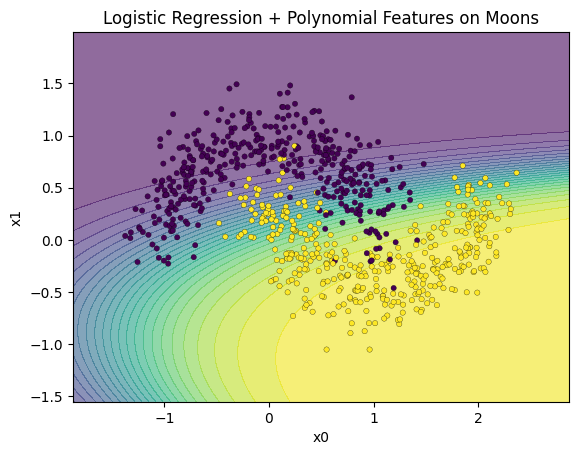

In [28]:
poly_pipe = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler(with_mean=False)),
    ("logreg", LogisticRegression(max_iter=3000, random_state=RANDOM_STATE))
])
poly_pipe.fit(X_2d, y_2d)
plot_decision_boundary_2d(poly_pipe, X_2d, y_2d, title="Logistic Regression + Polynomial Features on Moons")

## 14. Probability Calibration (Reliability Curve)

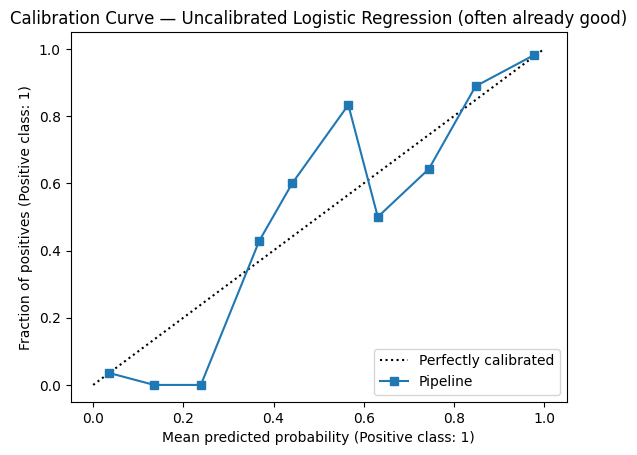

In [29]:
CalibrationDisplay.from_estimator(pipe, Xte, yte, n_bins=10)
plt.title("Calibration Curve — Uncalibrated Logistic Regression (often already good)")
plt.show()

## 15. Multiclass Logistic Regression (One-vs-Rest)

In [30]:
iris = load_iris()
Xi, yi = iris.data, iris.target
Xi_tr, Xi_te, yi_tr, yi_te = train_test_split(Xi, yi, test_size=0.25, stratify=yi, random_state=RANDOM_STATE)

multi = Pipeline([("scaler", StandardScaler()),
                  ("logreg", LogisticRegression(multi_class="ovr", max_iter=2000, random_state=RANDOM_STATE))])
multi.fit(Xi_tr, yi_tr)
pred = multi.predict(Xi_te)
print("Multiclass accuracy (Iris):", accuracy_score(yi_te, pred))
print("\nClassification report:\n", classification_report(yi_te, pred))

Multiclass accuracy (Iris): 0.8157894736842105

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.75      0.69      0.72        13
           2       0.73      0.85      0.79        13

    accuracy                           0.82        38
   macro avg       0.83      0.82      0.82        38
weighted avg       0.82      0.82      0.82        38



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


## 16. Save & Load Your Model

In [31]:
# Adjust the path as you like:
save_path = "logreg_pipeline.joblib"
joblib.dump(best_model, save_path)
print("Saved to:", save_path)

loaded = joblib.load(save_path)
print("Loaded model test ROC AUC:", roc_auc_score(yte, loaded.predict_proba(Xte)[:,1]))

Saved to: logreg_pipeline.joblib
Loaded model test ROC AUC: 0.9710209342637449


## 17. Common Pitfalls & Checklist

- **Feature scaling** matters for gradient descent and for interpreting coefficients.  
- Use **regularization** (L2 by default) to combat overfitting and multicollinearity.  
- For **imbalance**, tune **class weights** or adjust thresholds; evaluate with **PR-AUC**.  
- Prefer **pipelines** so that preprocessing is consistently applied in CV and production.  
- Always validate with **cross-validation** and **proper metrics** beyond accuracy.  
- Inspect **coefficients** via odds ratios; beware of correlated features.  
- For non-linear boundaries, consider **feature engineering** (e.g., polynomial features).

## 18. Exercises (Try These!)

1. Replace `make_classification` with your own dataset and rerun the full pipeline.  
2. Modify the from-scratch trainer to include **L1** (Lasso) regularization via subgradient.  
3. Implement a **learning-rate schedule** (e.g., `lr_t = lr_0 / (1 + decay * t)`) and compare loss curves.  
4. Tune the **decision threshold** to maximize F1 on the validation set. Plot F1 vs threshold.  
5. Extend the from-scratch implementation to **multiclass** using One-vs-Rest.  
6. Add **calibration** via `CalibratedClassifierCV` and compare calibration curves.  
7. Create a **regularization path** for L1 and analyze sparsity patterns in coefficients.